<a href="https://colab.research.google.com/github/CWill22/NeuralHW14/blob/main/lfp_state_classification_read_data_CNN_LSTM(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab tutorial for uploading data.

https://colab.research.google.com/notebooks/io.ipynb

In [19]:
import h5py
import numpy as np

filepath = 'Rat08-20130711_017.h5'  # data file
f = h5py.File(filepath, 'r')  # read data with h5 format
fs = f.attrs['fs'][0]  # get sampling frequency of LFP signal (Hz)
print("Sampling rate: %.1f Hz" % (fs))

Sampling rate: 1250.0 Hz


In [20]:
states = []  # two states (NREM & WAKE) to be classified
# LFP recordings are store in two h5 groups for each state
# Under each h5 group, the LFP recordings are divided into several segments with different lengths.
for name, grp in f.items():
  states.append(name)
  print("State: %s" % (name))
  print("Segment IDs:")
  print(list(grp.keys()))

State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7', '8', '9']


In [21]:
# Convert the recording in to numpy arrays
# Use a dictionary to store the LFP recordings of the two states
# each containing a list of numpy arrays of all segments
lfp = {key: [] for key in states}
for key in states:
  group = f[key]  # h5 group of a state
  n = len(group)  # number of segments
  for i in range(n):
    lfp[key].append(group[str(i+1)][()].astype(float))  # convert data to numpy array and from int type to float type

# print(lfp)

Example for accessing a segment.

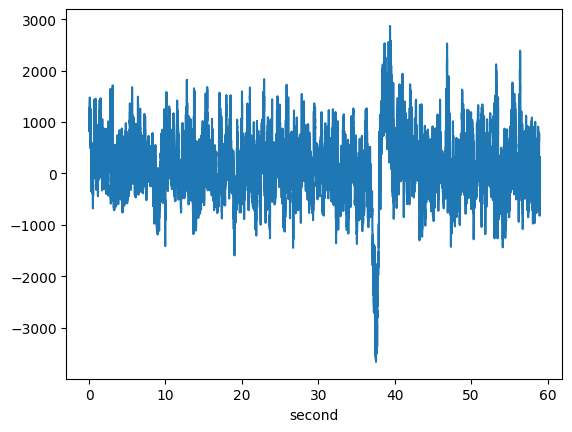

In [22]:
import matplotlib.pyplot as plt

x = lfp['NREM'][10]  # accessing the 10-th LFP segment in NREM state
t = np.arange(x.size)/fs  # time points

plt.plot(t,x)
plt.xlabel('second')
plt.show()

# LFP State Classification with a Fully Connected Neural Network


In [23]:
# Cell 1: Import Libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(18)
torch.manual_seed(18)


## Data Loading

In [24]:
def load_data(file_path):
    """
    Loads the H5 file and returns a dictionary where each key corresponds to a brain state (e.g., NREM, WAKE)
    and the associated value is a numpy array of the signal.

    If the key corresponds to a group, this function attempts to load either a dataset named 'data'
    (if available) or the first dataset found in the group.
    """
    import h5py  # ensure h5py is imported within function if not already
    with h5py.File(file_path, 'r') as f:
        keys = list(f.keys())
        print("Keys found in {}: {}".format(file_path, keys))
        state_data = {}
        for key in keys:
            item = f[key]
            # Check if the item is a dataset
            if isinstance(item, h5py.Dataset):
                state_data[key] = item[:]   # load the dataset directly
            elif isinstance(item, h5py.Group):
                sub_keys = list(item.keys())
                print("Key '{}' is a group with sub-keys: {}".format(key, sub_keys))
                # Look for a dataset named 'data'
                if 'data' in sub_keys:
                    state_data[key] = item['data'][:]
                elif len(sub_keys) > 0:
                    # If no 'data' key exists, load the first dataset available in the group
                    first_key = sub_keys[0]
                    state_data[key] = item[first_key][:]
                else:
                    raise ValueError("Group '{}' is empty in file {}.".format(key, file_path))
            else:
                raise TypeError("Key {} is neither a Group nor a Dataset.".format(key))
    return state_data

# List of file paths (update with correct paths if necessary)
file_paths = [
    'Part1SubjectHB10.h5',
    'Rat08-20130711_017.h5',
    'Part2SubjectHB13.h5'
]

# Load data from the files into a list of dictionaries.
all_subjects_data = [load_data(fp) for fp in file_paths]


Keys found in Part1SubjectHB10.h5: ['NREM', 'WAKE']
Key 'NREM' is a group with sub-keys: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']
Key 'WAKE' is a group with sub-keys: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '4', '5', '6', '7', '8', '9']
Keys found in Rat08-20130711_017.h5: ['NREM', 'WAKE']
Key 'NREM' is a group with sub-keys: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '7', '8', '9']
Key 'WAKE' is a group with sub-keys: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22

## Preprocessing and Feature Extraction

### 1. Segmenting the Signal
We segment each recording into non-overlapping clips of fixed length (e.g. 5 seconds).  
We assume the sampling frequency is fs = 1000 Hz (i.e. 1000 samples per second).

### 2. Extracting Features
For each clip we extract time-domain features (mean, standard deviation, skewness, kurtosis) and frequency-domain features. In the frequency domain we compute the power spectral density (PSD) using Welch’s method and extract:
- Total power
- Relative power in classic frequency bands:
  - Delta (0.5–4 Hz)
  - Theta (4–8 Hz)
  - Alpha (8–12 Hz)
  - Beta (12–30 Hz)

These features are concatenated to form a feature vector per clip.


In [25]:
# Cell 3: Define Signal Segmentation and Feature Extraction

fs = 1000                # Sampling frequency in Hz
clip_length_sec = 5      # Duration of each clip in seconds
clip_length_samples = fs * clip_length_sec

def segment_signal(signal, clip_length_samples):
    """
    Segments the signal into non-overlapping clips.
    """
    n_samples = len(signal)
    clips = []
    # Step in non-overlapping windows
    for start in range(0, n_samples - clip_length_samples + 1, clip_length_samples):
        clip = signal[start:start+clip_length_samples]
        clips.append(clip)
    return clips

def extract_features(clip, fs):
    """
    Given a clip, compute time-domain and frequency-domain features.
    Returns a feature vector.
    """
    # Time-domain features
    mean_val = np.mean(clip)
    std_val = np.std(clip)
    skew_val = skew(clip)
    kurt_val = kurtosis(clip)

    # Frequency-domain: compute PSD using Welch's method.
    f_vals, pxx = welch(clip, fs=fs, nperseg=fs//2)

    # Total power of the signal
    total_power = np.sum(pxx) + 1e-9  # add small number to avoid division by zero

    # Helper function: power in a frequency band
    def band_power(f, pxx, low, high):
        idx = np.logical_and(f >= low, f < high)
        return np.sum(pxx[idx])

    delta_power = band_power(f_vals, pxx, 0.5, 4)
    theta_power = band_power(f_vals, pxx, 4, 8)
    alpha_power = band_power(f_vals, pxx, 8, 12)
    beta_power = band_power(f_vals, pxx, 12, 30)

    # Compute relative band powers
    delta_rel = delta_power / total_power
    theta_rel = theta_power / total_power
    alpha_rel = alpha_power / total_power
    beta_rel = beta_power / total_power

    # Concatenate all features: time-domain features, total power, and relative band powers.
    features = np.array([
        mean_val, std_val, skew_val, kurt_val,
        total_power, delta_rel, theta_rel, alpha_rel, beta_rel
    ])

    return features


## Building the Feature Dataset

Next, we loop over the subjects and for each state (NREM and WAKE) we segment the raw LFP signal into clips, compute the features, and assign labels:
- Label 0: NREM  
- Label 1: WAKE  

After combining all clips, we normalize the features and split the dataset into training and testing sets.


In [26]:
# Cell 4: Create Dataset for Classification

X_all = []
y_all = []

# For each subject file
for subject_data in all_subjects_data:
    for state, signal in subject_data.items():
        # Check that the signal is one-dimensional (if not, select the desired channel)
        if signal.ndim > 1:
            signal = signal.flatten()

        # Segment the signal into clips
        clips = segment_signal(signal, clip_length_samples)
        print("Number of clips for state {}: {}".format(state, len(clips)))

        # Extract features for each clip
        for clip in clips:
            feat = extract_features(clip, fs)
            X_all.append(feat)
            # Assign a label based on state name
            if state.upper() == 'NREM':
                y_all.append(0)
            elif state.upper() == 'WAKE':
                y_all.append(1)
            else:
                # non-standard state names
                continue

X_all = np.array(X_all)
y_all = np.array(y_all)

print("Total samples: {}, Feature vector length: {}".format(X_all.shape[0], X_all.shape[1]))

# Normalize features
scaler = StandardScaler()
X_all_norm = scaler.fit_transform(X_all)

# Split dataset into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_all_norm, y_all, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader objects for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


Number of clips for state NREM: 24
Number of clips for state WAKE: 12
Number of clips for state NREM: 22
Number of clips for state WAKE: 83
Number of clips for state NREM: 12
Number of clips for state WAKE: 49
Total samples: 202, Feature vector length: 9


## Building the Neural Network with PyTorch

We define a simple feedforward neural network with one hidden layer. The network uses ReLU activation and has an output layer with two neurons corresponding to the two classes.


In [27]:
# Cell 5: Define the Model

class LFPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(LFPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 2)  # 2 classes: NREM and WAKE

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_dim = X_all_norm.shape[1]
model = LFPClassifier(input_dim)
print(model)


LFPClassifier(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


## Training the Model

We set up the loss function (cross-entropy) and the Adam optimizer. Then we train the network over a number of epochs while tracking the training loss. We also evaluate the model on the test set to monitor its performance.


In [28]:
# Cell 6: Training Loop

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
train_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)

    print("Epoch [{}/{}]: Loss = {:.4f}, Test Accuracy = {:.4f}".format(epoch+1, n_epochs, epoch_loss, test_accuracy))


Epoch [1/100]: Loss = 0.6065, Test Accuracy = 0.7805
Epoch [2/100]: Loss = 0.5735, Test Accuracy = 0.8537
Epoch [3/100]: Loss = 0.5453, Test Accuracy = 0.8537
Epoch [4/100]: Loss = 0.5217, Test Accuracy = 0.8537
Epoch [5/100]: Loss = 0.5029, Test Accuracy = 0.8537
Epoch [6/100]: Loss = 0.4874, Test Accuracy = 0.8537
Epoch [7/100]: Loss = 0.4743, Test Accuracy = 0.8537
Epoch [8/100]: Loss = 0.4643, Test Accuracy = 0.8537
Epoch [9/100]: Loss = 0.4530, Test Accuracy = 0.8537
Epoch [10/100]: Loss = 0.4440, Test Accuracy = 0.8780
Epoch [11/100]: Loss = 0.4348, Test Accuracy = 0.8780
Epoch [12/100]: Loss = 0.4249, Test Accuracy = 0.8780
Epoch [13/100]: Loss = 0.4147, Test Accuracy = 0.8780
Epoch [14/100]: Loss = 0.4047, Test Accuracy = 0.8780
Epoch [15/100]: Loss = 0.3946, Test Accuracy = 0.8780
Epoch [16/100]: Loss = 0.3862, Test Accuracy = 0.8780
Epoch [17/100]: Loss = 0.3787, Test Accuracy = 0.8780
Epoch [18/100]: Loss = 0.3713, Test Accuracy = 0.8780
Epoch [19/100]: Loss = 0.3636, Test A

## Results

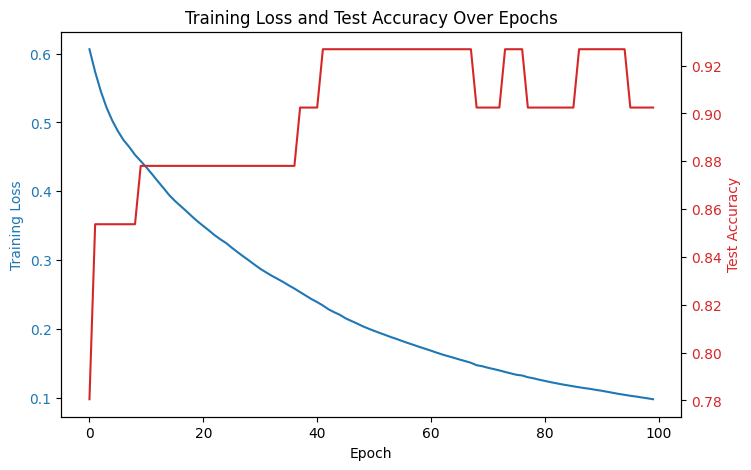

In [29]:
# Cell 7: Plot Training Loss and Test Accuracy

fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.plot(train_losses, color=color)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Training Loss and Test Accuracy Over Epochs')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(test_accuracies, color=color)
ax2.set_ylabel('Test Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()


## Summary and Conclusions

- **Data Preprocessing:** We loaded LFP recordings from three subjects and segmented the continuous recordings into non-overlapping 5-second clips. For each clip, a set of features was engineered including statistical measures and relative band power (delta, theta, alpha, beta).

- **Modeling:** A simple fully connected neural network (with one hidden layer) was used to classify the clips into NREM and WAKE states. We trained the model using the cross-entropy loss and the Adam optimizer.

- **Performance & Improvements:**  
  - **Feature Extraction:** The performance of the classifier depends greatly on the quality of the features. In addition to the features used here, I could experiment with additional features, such as features based on bandpass-filtered signals or more sophisticated time-frequency analyses.
  - **Clip Length:** I could experiment with using shorter clips, as they can lead to lower classification accuracy due to less data per sample. A trade-off exists between time resolution and classification performance.
  - **Model Architecture:** More complex architectures (e.g. deeper networks or convolutional layers for direct processing of raw LFP data) might improve performance, although they require larger training data and careful regularization.

- **Issues Encountered:**  
  - **Test Accuracy Going Down Then Back Up** When I was trying different seeds, the test accuracy would sometimes jump around but always show a pattern of mostly increasing accuracy over epochs. This makes sense as fitting the dataset to the training data can sometimes cause it to miss some testing data. I just have to make sure it does not do it too much, as that would be an overfitting problem. I increased the amount of epochs to see if it was a problem once the model converged more.
  - **Data Imbalance:** I verified that there is a similar number of samples for each state. If not, I may need to apply balancing techniques or adjust the loss function.
  - **Feature Normalization:** I ensured that features were on similar scales (via z-score normalization). This proved important for stable network training.
  - **Model Overfitting:** I could moniter the validation performance and may consider using techniques like dropout, early stopping, or regularization to reduce overfitting.

# HW13:
**Using CNN**



A CNN applies 1D (or 2D) filters that slide across the input to detect local patterns.  
- **Convolutional layers** extract features invariant to small shifts.  
- **Pooling layers** downsample and provide translational invariance.  
- Stacking many conv + pooling blocks learns hierarchical representations.  

Here we treat our raw LFP time-series as a 1D “image” and let the CNN learn local rhythmic patterns that distinguish NREM vs WAKE.




Prepare data

In [30]:
# Cell: Prepare & Load Short Clips for CNN (memory‐safe)

import h5py, numpy as np, torch
from torch.utils.data import Dataset, DataLoader

# 1) Load H5, get fs and all segments
filepath = 'Rat08-20130711_017.h5'
with h5py.File(filepath, 'r') as f:
    fs = int(f.attrs['fs'][0])
    raw_states = {
        state: [f[state][k][()].astype(np.float32)
                for k in f[state].keys()]
        for state in f.keys()
    }

# 2) Define clip length in seconds & samples
clip_sec = 2
clip_len = fs * clip_sec    # e.g. 3000 samples if fs=1000

# 3) Slide non‐overlapping window to create fixed‐length clips
all_X, all_y = [], []
label_map = {'NREM':0, 'WAKE':1}

for state, segs in raw_states.items():
    for sig in segs:
        n = sig.shape[0]
        # how many full clips fit?
        n_clips = n // clip_len
        for i in range(n_clips):
            start = i * clip_len
            clip  = sig[start:start+clip_len]
            all_X.append(clip)
            all_y.append(label_map[state])

all_X = np.stack(all_X, axis=0)  # (N_clips, clip_len)
all_y = np.array(all_y, dtype=np.int64)

print("Total clips:", all_X.shape[0], "Clip length:", all_X.shape[1])

# 4) Dataset + DataLoaders
class LFPClipDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).unsqueeze(1)  # → (N,1,clip_len)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

dataset = LFPClipDataset(all_X, all_y)

# 5) Train/test split
n = len(dataset)
idx = np.arange(n)
np.random.seed(42); np.random.shuffle(idx)
split = int(0.8 * n)
train_idx, test_idx = idx[:split], idx[split:]

from torch.utils.data import Subset
train_ds = Subset(dataset, train_idx)
test_ds  = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds,  batch_size=8, shuffle=True,  pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, pin_memory=True)

print("Batches – train:", len(train_loader), "test:", len(test_loader))


Total clips: 9280 Clip length: 2500
Batches – train: 928 test: 232


**Defining a 1D-CNN Model**

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class LFP_CNN(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, padding=2)
        self.pool  = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        # after two pool-by-2’s, length = seq_len // 4
        self.fc1   = nn.Linear(32 * (seq_len // 4), 64)
        self.fc2   = nn.Linear(64, 2)

    def forward(self, x):
        # x: (B,1,L)
        x = self.pool(F.relu(self.conv1(x)))   # → (B,16,L/2)
        x = self.pool(F.relu(self.conv2(x)))   # → (B,32,L/4)
        x = x.flatten(1)                       # → (B, 32*(L/4))
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_cnn = LFP_CNN(seq_len = X_pad.shape[1]).to(device)
model_cnn = LFP_CNN(seq_len=clip_len).to(device)
print(model_cnn)


LFP_CNN(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc1): Linear(in_features=20000, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


Train and Evaluate

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

def train_epoch(model, loader):
    model.train()
    running_loss, N = 0.0, 0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
        N += Xb.size(0)
    return running_loss / N

def eval_model(model, loader):
    model.eval()
    correct, N = 0, 0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            N += yb.size(0)
    return correct / N

# --- CNN training with metric recording ---
cnn_train_losses, cnn_test_accuracies = [], []

n_epochs = 10
for epoch in range(1, n_epochs+1):
    tr_loss = train_epoch(model_cnn, train_loader)
    te_acc  = eval_model(model_cnn, test_loader)
    cnn_train_losses.append(tr_loss)
    cnn_test_accuracies.append(te_acc)
    print(f"[CNN] Epoch {epoch}/{n_epochs} — loss: {tr_loss:.4f}, test acc: {te_acc:.3f}")



[CNN] Epoch 1/10 — loss: 2.3340, test acc: 0.713
[CNN] Epoch 2/10 — loss: 0.4379, test acc: 0.755
[CNN] Epoch 3/10 — loss: 0.3004, test acc: 0.745
[CNN] Epoch 4/10 — loss: 0.2149, test acc: 0.770
[CNN] Epoch 5/10 — loss: 0.1719, test acc: 0.763
[CNN] Epoch 6/10 — loss: 0.1748, test acc: 0.737
[CNN] Epoch 7/10 — loss: 0.1193, test acc: 0.745
[CNN] Epoch 8/10 — loss: 0.0850, test acc: 0.751
[CNN] Epoch 9/10 — loss: 0.0902, test acc: 0.769
[CNN] Epoch 10/10 — loss: 0.0909, test acc: 0.753


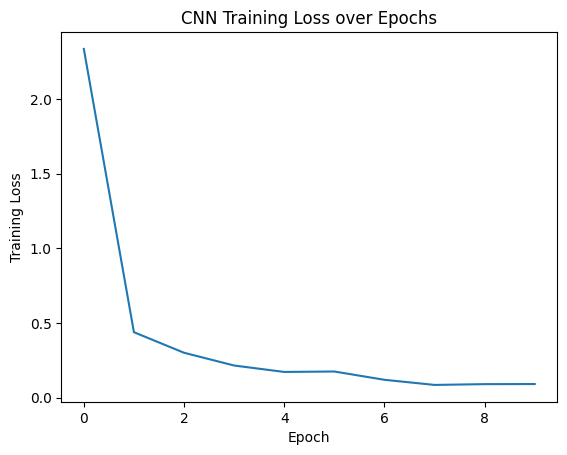

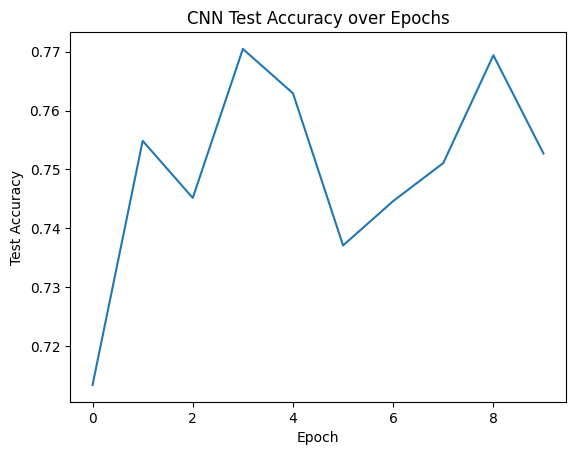

In [33]:
import matplotlib.pyplot as plt

# CNN: Training Loss
plt.figure()
plt.plot(cnn_train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('CNN Training Loss over Epochs')
plt.show()

# CNN: Test Accuracy
plt.figure()
plt.plot(cnn_test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('CNN Test Accuracy over Epochs')
plt.show()

**Using LSTM**

An LSTM is a type of RNN that can learn long-range dependencies via gated cells:
- **Input gate** controls what new information enters the cell.
- **Forget gate** decides what to discard.
- **Output gate** selects what to pass on.
- Keeps a **cell state** to carry memory across many steps.

Here we feed each timepoint sequentially into the LSTM to capture temporal dynamics in the LFP.


Defining LSTM Model

In [34]:
class LFP_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=False)
        self.fc   = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: [B,1,L] → permute to [B,L,1]
        x = x.permute(0,2,1)
        out, _ = self.lstm(x)           # out: [B, L, hidden_size]
        # take last time step
        last = out[:, -1, :]            # [B, hidden_size]
        return self.fc(last)

model_lstm = LFP_LSTM().to(device)
optimizer_l = optim.Adam(model_lstm.parameters(), lr=1e-3)
criterion_l = nn.CrossEntropyLoss()


Train and Evalaute

In [35]:
def train_epoch_lstm(model, loader):
    model.train()
    total_loss, count = 0,0
    for Xb,yb in loader:
        Xb,yb = Xb.to(device), yb.to(device)
        optimizer_l.zero_grad()
        logits = model(Xb)
        loss   = criterion_l(logits, yb)
        loss.backward(); optimizer_l.step()
        total_loss += loss.item() * Xb.size(0)
        count += Xb.size(0)
    return total_loss/count

def eval_lstm(model, loader):
    model.eval()
    correct, total= 0,0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb,yb = Xb.to(device), yb.to(device)
            preds = model(Xb).argmax(dim=1)
            correct += (preds==yb).sum().item()
            total   += yb.size(0)
    return correct/total

# --- LSTM training with metric recording ---
lstm_train_losses, lstm_test_accuracies = [], []

for epoch in range(1, n_epochs+1):
    tr_loss = train_epoch_lstm(model_lstm, train_loader)
    te_acc  = eval_lstm(model_lstm, test_loader)
    lstm_train_losses.append(tr_loss)
    lstm_test_accuracies.append(te_acc)
    print(f"[LSTM] Epoch {epoch}/{n_epochs} — loss: {tr_loss:.4f}, test acc: {te_acc:.3f}")


[LSTM] Epoch 1/10 — loss: 0.6392, test acc: 0.659
[LSTM] Epoch 2/10 — loss: 0.6305, test acc: 0.666
[LSTM] Epoch 3/10 — loss: 0.6228, test acc: 0.658
[LSTM] Epoch 4/10 — loss: 0.6160, test acc: 0.680
[LSTM] Epoch 5/10 — loss: 0.6293, test acc: 0.657
[LSTM] Epoch 6/10 — loss: 0.6191, test acc: 0.675
[LSTM] Epoch 7/10 — loss: 0.6140, test acc: 0.668
[LSTM] Epoch 8/10 — loss: 0.6067, test acc: 0.668
[LSTM] Epoch 9/10 — loss: 0.5921, test acc: 0.681
[LSTM] Epoch 10/10 — loss: 0.5668, test acc: 0.683


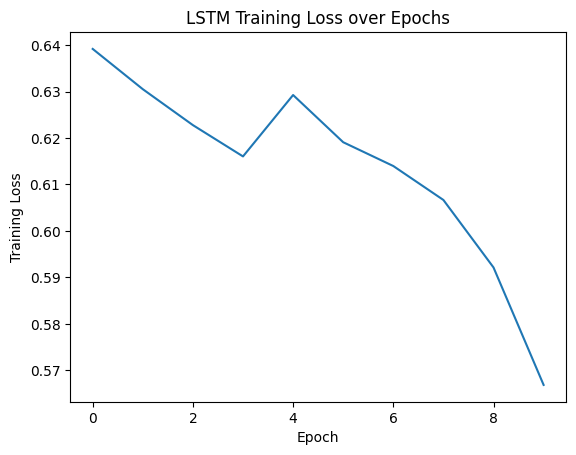

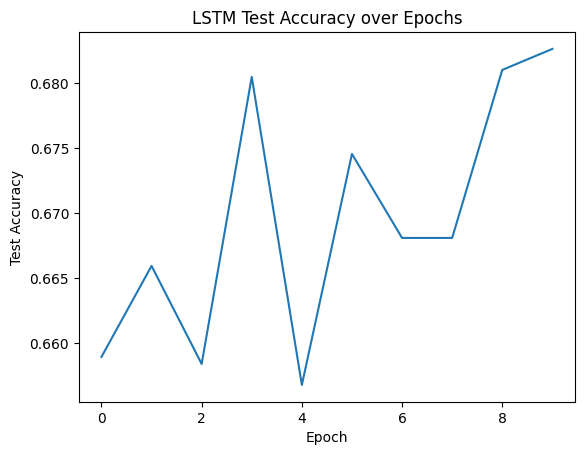

In [36]:
import matplotlib.pyplot as plt

# LSTM: Training Loss
plt.figure()
plt.plot(lstm_train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('LSTM Training Loss over Epochs')
plt.show()

# LSTM: Test Accuracy
plt.figure()
plt.plot(lstm_test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('LSTM Test Accuracy over Epochs')
plt.show()